nan
2.1301738611946486


C:\Users\GCU\AppData\Local\Temp\ipykernel_22620\3521274630.py:91: RuntimeWarning: divide by zero encountered in divide
  F_muf = A_wall * (f_pipe * (x_limit / D_chamber) * (1 / (2 * g)) * v_avg_array**2)
C:\Users\GCU\AppData\Local\Temp\ipykernel_22620\3521274630.py:91: RuntimeWarning: invalid value encountered in multiply
  F_muf = A_wall * (f_pipe * (x_limit / D_chamber) * (1 / (2 * g)) * v_avg_array**2)


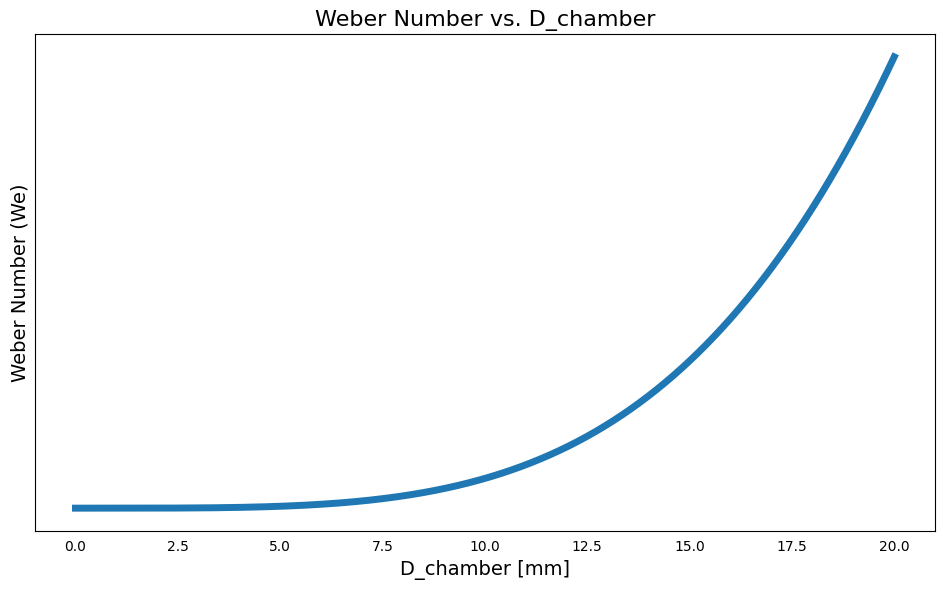

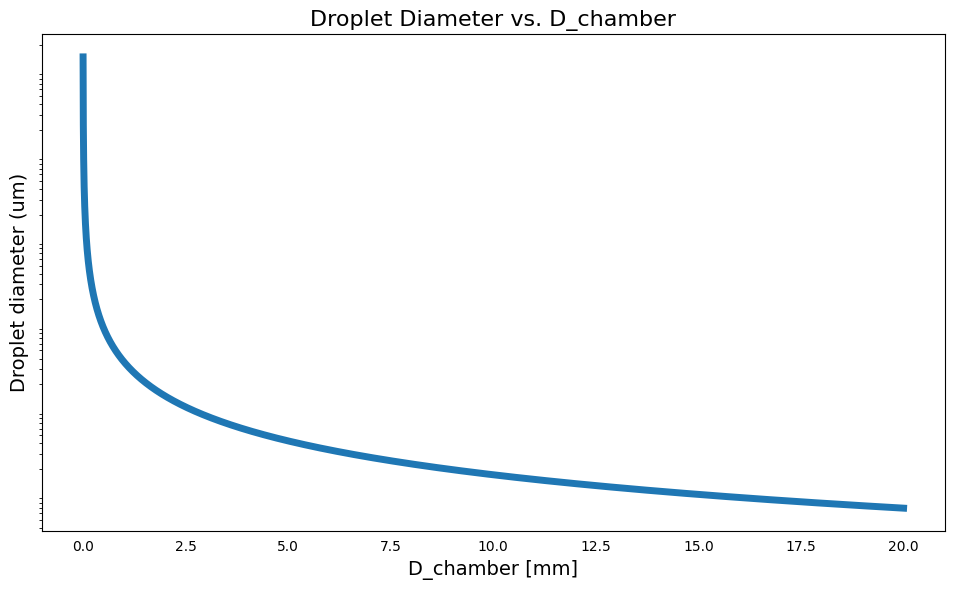

In [15]:
# 피스톤이 stroke limit에 도달한 시점의 시간 t_stop을 계산해서 감쇠항에 반영

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 변수 요소
m = 0.02  # kg 피스톤 질량
x_limit = 10 * 1e-3  # m 피스톤 변위
D1 = 2.4 * 1e-3 # m 노즐 인렛 직경
D2 = 0.2 * 1e-3 # m 노즐 아웃렛 직경
L1 = 20.87 * 1e-3 # m 노즐 인렛 길이
L2 = 5.0 * 1e-3 # m 노즐 아웃렛 길이
k1 = 2660 # N/m 첫번째 피스톤 상수
k2 = 1260 # N/m 두번째 피스톤 상수
L_open = 1.0 * 1e-3 # m k1 누르는 길이
t_final = 0.1 # 없어도 코드 돌아김김
F_finger = 20 # N 손가락 힘


# ✅ 1. 상수 정의
K = 0.9 # 충돌 수두손실 계수
f_pipe = 0.03 # 유체 점성 수두손실 계수
A_in = (np.pi / 4) * D1**2 # m^2 노즐 인렛 넓이
rho = 1000  # kg/m^3 물 밀도
g = 9.81  # m/s^2
sigma = 0.0728  # N/m 표면장력 (물/공기기)
f_gap = 0.3 # 패킹 마찰 계수
E = 1e9 # Pa PP 탄성계수
delta_gap = 0.001 * 1e-3 # m 패킹 간극
h_packing = 1 * 1e-3 # m 패킹 길이


# 병렬 스프링 등가 강성
k = (k1 * k2) / (k1 + k2)

# ✅ 2. D_chamber 정의
D_chamber = np.linspace(0, 0.02, 10000)
A_chamber = (np.pi / 4) * D_chamber**2

# ✅ 3. 평균 속도 및 도달 시간 계산
v_avg_array = []
t_stop_array = []

for A_ch in A_chamber:
    c = (rho * 1.0 * A_ch) / 2

    def force(t):
        return 20.0

    def mck_system(t, y):
        x, v = y
        dxdt = v
        dvdt = (force(t) - c * v - k * x) / m
        return [dxdt, dvdt]

    def reach_stroke_limit(t, y):
        return y[0] - x_limit
    reach_stroke_limit.terminal = True
    reach_stroke_limit.direction = 1

    y0 = [0.0, 0.0]
    t_span = (0, t_final)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    sol = solve_ivp(
        mck_system,
        t_span,
        y0,
        t_eval=t_eval,
        events=reach_stroke_limit
    )

    v = sol.y[1]
    v_avg = np.mean(v)
    v_avg_array.append(v_avg)

    # 도달 시점 시간 저장
    t_stop = sol.t_events[0][0] if len(sol.t_events[0]) > 0 else t_final
    t_stop_array.append(t_stop)

v_avg_array = np.array(v_avg_array)
t_stop_array = np.array(t_stop_array)

# ✅ 4. Weber 수 계산
geom_term = np.sqrt((1 - f_pipe * L1 / D1) * (1 - K) * (1 - f_pipe * L2 / D2))
A_term = ((rho * D2 / sigma) * ((A_chamber / A_in) * geom_term))**2

F_friction = 2 * np.pi * f_gap * E * delta_gap * h_packing
A_wall = np.pi * D_chamber * x_limit
F_muf = A_wall * (f_pipe * (x_limit / D_chamber) * (1 / (2 * g)) * v_avg_array**2)
F_open = k1 * L_open
F_total = F_finger - F_friction - F_muf - F_open
B_term = np.clip(F_total, 0, None)**2

c_array = (rho * v_avg_array * A_chamber) / 2
zeta = c_array / (2 * np.sqrt(m * k2))
omega_n = np.sqrt(k2 / m)
omega_d = omega_n * np.sqrt(1 - zeta**2)

exp_term = np.exp(-zeta * omega_n * t_stop_array)
dyn_term = (
    zeta * omega_n * (np.cos(omega_d * t_stop_array) + (zeta * omega_n / omega_d) * np.sin(omega_d * t_stop_array))
    - omega_d * (-np.sin(omega_d * t_stop_array) + (zeta * omega_n / omega_d) * np.cos(omega_d * t_stop_array))
)
C_term = ((exp_term / k2)**2) * (dyn_term**2)

# ✅ 최종 We 수
We = A_term * B_term * C_term
D_particle = 1.95 * D2 * (1.293 / rho)**(-1/6) * (We**(-1/3))


print(max(F_total))
print(np.max(v_avg_array))

# ✅ 5. 그래프 출력

lw = 5

plt.figure(figsize=(10, 6))
plt.plot(D_chamber * 1000, We, lw=lw)
plt.xlabel('D_chamber [mm]',fontsize=14)
plt.ylabel('Weber Number (We)',fontsize=14)
plt.title('Weber Number vs. D_chamber',fontsize=16)
#plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])  # y축 눈금 제거
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(D_chamber * 1000, D_particle*1000 , lw=lw)
plt.xlabel('D_chamber [mm]',fontsize=14)
plt.ylabel('Droplet diameter (um)',fontsize=14)
plt.title('Droplet Diameter vs. D_chamber',fontsize=16)
plt.yscale("log")
#plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])  # y축 눈금 제거
plt.show()
